<a href="https://colab.research.google.com/github/trbella/2022-05-environment_international/blob/main/notebooks/best_models/LSTM/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**READ ME**: 
**Notebook made by Thiago Ribas**: 

In this notebook I fitted the best LSTM models for daily, weekly and monthly data.


##**REQUIREMENTS**

In [66]:
#uploading the requirements.txt file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 1153 bytes


##**INSTALLING REQUIREMENTS**

In [ ]:
!pip install -r requirements.txt

###**Packages**

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras.callbacks import EarlyStopping
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


###**Functions**

In [69]:
# MAPE FUNCTION
def mape_vectorized(true, pred): 
    mask = true != 0
    return (np.fabs(true - pred)/true)[mask].mean()*100
#==================================================================
# VIF FUNCTION
#from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["VARIAVEIS"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
#==================================================================
# series_to_supervised FUNCTION

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #identifica a quantidade de variaveis do dataset
  n_vars = 1 if type(data) is list else data.shape[1]
  #transforma em dataframe pandas
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1). Quantidade de lags antes do tempo t
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n). Quantidade de lags depois do tempo t
    '''
  É esse o argumento da função que alteraremos quando for usar, caso adotemos
  a previsão para 2 dias ou mais na frente. O padrão está como 
  previsão do tempo (t) --> n_out=1, que foi o utilizado pelo Jason.
    '''
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

##**Spliting Endogenous and Exogenous Variables**

I decided to maintain only some exogenous variables to fit the model:

- **CARBON MONOXIDE**: We chose to work with mean levels of CO (**CO_MEAN**).
- **PARTICULATE MATTER 10 um**: We chose to work with mean levels of PM10 (**PM10_MEAN**).
- **TEMPERATURE**: We chose **TMIN** only for **IAC** (**TMIN_IAC**) due its good precision.

The best LSTM models in each frequency were:

- Daily: 
    - variables:T_MIN and CO_MEAN
    - lags: 13

- weekly:
    - variables: T_MIN and CO_MEAN
    - lags: 3

- Monthly:
    - variables: T_MIN, CO_MEAN and PM10_MEAN
    - lags: 3


#**DAILY DATA**

##**LOAD DATA**

In [3]:
df = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Obitos_SSC/data/processed/2001-2018_obitos_clima_diario.csv')
df['DATE'] = pd.to_datetime(df['DATE'],dayfirst=True)
df = df.set_index('DATE')
df.head(3)

,CO_MIN,CO_MAX,CO_MEAN,PM10_MIN,PM10_MAX,PM10_MEAN,TMIN_IAC,TMAX_IAC,TMIN_VC,TMAX_VC,...,mi_black_F,avc_white,avc_brown,avc_black,avc_white_M,avc_brown_M,avc_black_M,avc_white_F,avc_brown_F,avc_black_F
DATE,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.6,1.2,0.804348,NaN,NaN,NaN,18.2,28.2,17.8,27.9,...,0,2,0,0,0,0,0,2,0,0
2001-01-02,0.4,1.9,1.078261,NaN,NaN,NaN,17.8,30.0,16.6,29.8,...,0,1,0,0,0,0,0,1,0,0
2001-01-03,0.4,2.5,1.239130,NaN,NaN,NaN,18.0,30.4,17.3,29.6,...,0,2,0,0,2,0,0,0,0,0


##**Deaths overview**

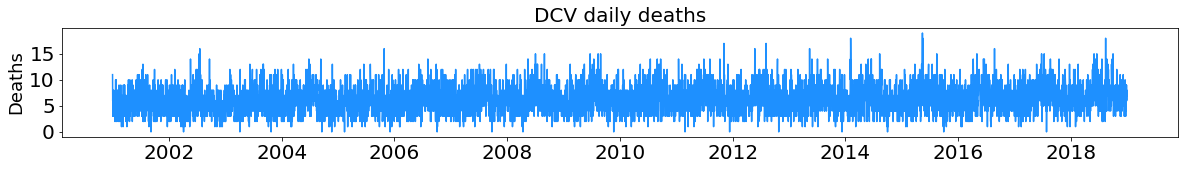

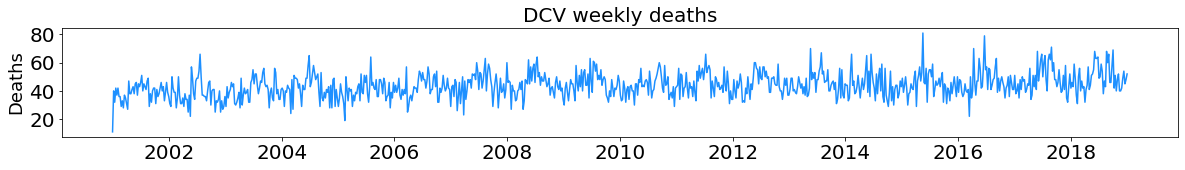

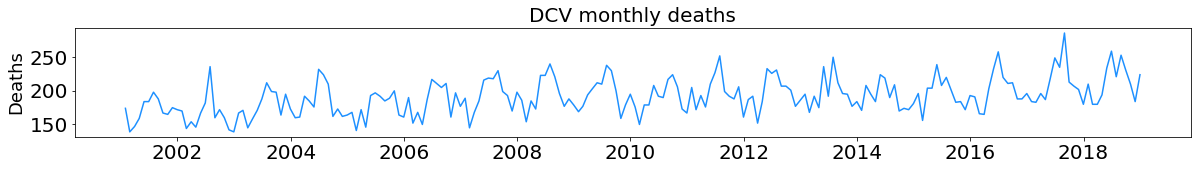

diario 6574
semanal 940
mensal 216


In [7]:
#a = {}
plt.figure(figsize=(20,2))
plt.title('DCV daily deaths',fontsize=20)
plt.plot(df['all'],color='dodgerblue')
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=20)
plt.xlabel('Time')
plt.ylabel('Deaths')
plt.yticks(fontsize=20)
plt.xlabel('')
plt.show()

semanal = df['all'].resample('W-MON',label='right').sum()
plt.figure(figsize=(20,2))
plt.title('DCV weekly deaths',fontsize=20)
plt.plot(semanal,color='dodgerblue')
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=20)
plt.xlabel('Time')
plt.ylabel('Deaths')
plt.yticks(fontsize=20)
plt.xlabel('')
plt.show()

mensal = df['all'].resample('M',label='right').sum()
plt.figure(figsize=(20,2))
plt.title('DCV monthly deaths',fontsize=20)
plt.plot(mensal,color='dodgerblue')
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=20)
plt.xlabel('Time')
plt.ylabel('Deaths')
plt.yticks(fontsize=20)
plt.xlabel('')
plt.show()

print('diario',len(df['all']))
print('semanal',len(semanal))
print('mensal',len(mensal))

In [8]:
# Variables
endog = df['all']
exog = df[['CO_MEAN','TMIN_IAC']]
endog = endog.asfreq('D')
exog = exog.asfreq('D')

#Check NaN
print('NaN count\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))

#fill exogenous nan with mean (for each exogenous variable)
exog = exog.fillna(exog.mean())

#Check NaN
print('NaN count\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))
exog.head(2)

NaN count

Endog             0
CO_MEAN     328
TMIN_IAC      0
dtype: int64
NaN count

Endog             0
CO_MEAN     0
TMIN_IAC    0
dtype: int64


,CO_MEAN,TMIN_IAC
DATE,,
2001-01-01,0.804348,18.2
2001-01-02,1.078261,17.8


##**Train/Test split 80%-20%**

In [9]:
n_train = int(0.8*len(df))

endog_train = endog.iloc[:n_train].asfreq('D')
endog_test = endog.iloc[n_train:].asfreq('D')

exog_train = exog.iloc[:n_train].asfreq('D')
exog_test = exog.iloc[n_train:].asfreq('D')

##**Normalization**

In [10]:
train = pd.merge(endog_train,exog_train,on='DATE')
test = pd.merge(endog_test,exog_test,on='DATE')
test.head(3)
train.head(3)

,all,CO_MEAN,TMIN_IAC
DATE,,,
2001-01-01,11,0.804348,18.2
2001-01-02,6,1.078261,17.8
2001-01-03,8,1.239130,18.0


In [13]:
'''
set mode = 0 if you want exog NOT containing endog
set mode = 1 if you want exog containing endog
'''
mode = 0

if mode == 1:
  flag = 0
else:
  flag = 1

# load dataset
values = train.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values = values.astype('float32')

# normalize train features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(values)
# normalize test based on train scaler
test_scaled = scaler.transform(test.values)
# specify the number of lag (hours in this case, since each line equals a hour)
#n_features is the number of the exogenous variables
n_hours = 13
n_features = len(exog.columns)+mode

##**Supervised Learning**

In [23]:
# frame as supervised learning
reframed = series_to_supervised(train_scaled[:,flag:], n_hours, 0)
reframed_test = series_to_supervised(test_scaled[:,flag:], n_hours, 0)
print(reframed.shape) #nº observation x ((nºfeatures + 1) * nºlags)
reframed.head()

(5246, 26)


,var1(t-13),var2(t-13),var1(t-12),var2(t-12),var1(t-11),var2(t-11),var1(t-10),var2(t-10),var1(t-9),var2(t-9),...,var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
13,0.143122,0.682243,0.191861,0.663551,0.220486,0.672897,0.207592,0.691589,0.237506,0.663551,...,0.230543,0.757009,0.269998,0.728972,0.268451,0.719626,0.315643,0.710280,0.262262,0.682243
14,0.191861,0.663551,0.220486,0.672897,0.207592,0.691589,0.237506,0.663551,0.211976,0.757009,...,0.269998,0.728972,0.268451,0.719626,0.315643,0.710280,0.262262,0.682243,0.202692,0.691589
15,0.220486,0.672897,0.207592,0.691589,0.237506,0.663551,0.211976,0.757009,0.167105,0.766355,...,0.268451,0.719626,0.315643,0.710280,0.262262,0.682243,0.202692,0.691589,0.269276,0.700935
16,0.207592,0.691589,0.237506,0.663551,0.211976,0.757009,0.167105,0.766355,0.251431,0.747664,...,0.315643,0.710280,0.262262,0.682243,0.202692,0.691589,0.269276,0.700935,0.307575,0.719626
17,0.237506,0.663551,0.211976,0.757009,0.167105,0.766355,0.251431,0.747664,0.230543,0.757009,...,0.262262,0.682243,0.202692,0.691589,0.269276,0.700935,0.307575,0.719626,0.235024,0.850467


##**Reframed as 3d data**

In [24]:
# split into train and test sets
values = reframed.values

# split into input and outputs
n_obs = n_hours * n_features

#Train and test
train_X, train_y = values, train_scaled[n_hours:,0]
test_X, test_y = reframed_test.values, test_scaled[n_hours:,0]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input (train_X and test_X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5246, 26) 5246 (5246,)
(5246, 13, 2) (5246,) (1302, 13, 2) (1302,)


##**LSTM Fit**

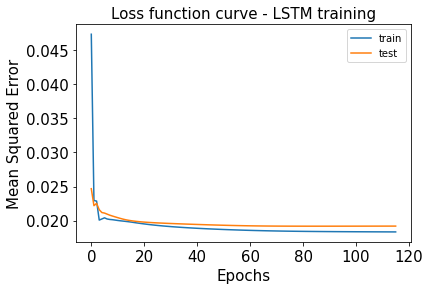

In [28]:
# design network
model = Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

#model compile
optimizer = tf.keras.optimizers.Adam() #optimizer
model.compile(loss='mse', optimizer=optimizer) #loss = mean squared error (mse)

# fit network
stop = EarlyStopping(monitor='val_loss', patience=30,verbose=0,restore_best_weights=True)
callbacks_list = [stop]
history = model.fit(train_X, train_y, epochs=300, batch_size=300, validation_data=(test_X, test_y),callbacks = callbacks_list, verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss function curve - LSTM training',fontsize=15)
plt.ylabel('Mean Squared Error',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)

##**Invert Scaler**

In [18]:
#Reshape test_X to get 7 random columns
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
n_features = n_features-mode

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -n_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
'''
We are only interested in inverting the target variable, but the transform requires 
the same columns when inverting as when transforming. Therefore we are adding 
the target variable with other input vars for the inverse operation.
'''
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -n_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mape = mape_vectorized(inv_y,inv_yhat)
print('Test MAPE: %.3f' % mape)

Test RMSE: 2.632
Test MAPE: 43.581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


##**Plot Prediction**

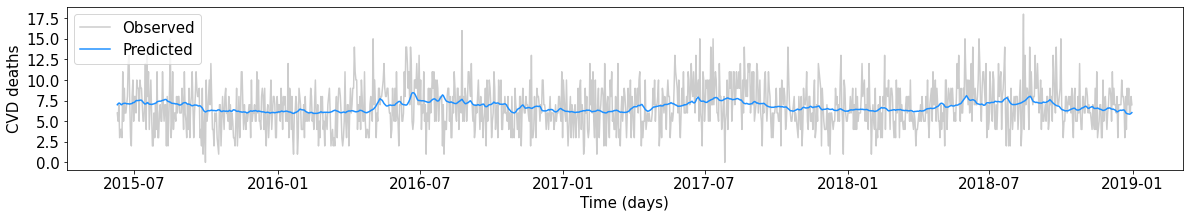

The mean value of the prediction is 6.76


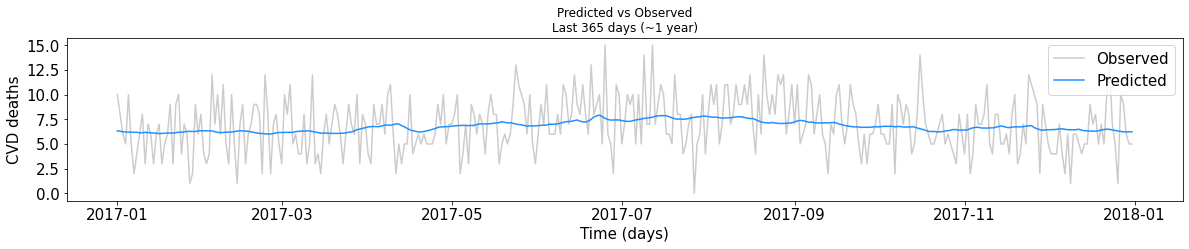

The mean value of the prediction is 6.76


In [22]:
# plot time series
plt.figure(figsize=[20,3])
plt.plot(test.iloc[n_hours:].index, inv_y[:], label='Observed',alpha=0.4,color='gray')
plt.plot(test.iloc[n_hours:].index, inv_yhat[:], label='Predicted',color='dodgerblue')
plt.xlabel('Time (days)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
plt.legend(fontsize=15,loc='upper left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

print(f'The mean value of the prediction is {round(inv_yhat.mean(),2)}')

# Zoom - last 1 year
plt.figure(figsize=[20,3])
plt.plot(test.iloc[-365*2:-365].index, inv_y[-365*2:-365], label='Observed',alpha=0.4,color='gray')
plt.plot(test.iloc[-365*2:-365].index, inv_yhat[-365*2:-365], label='Predicted',color='dodgerblue')
plt.title('Predicted vs Observed\nLast 365 days (~1 year)')
plt.xlabel('Time (days)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
print(f'The mean value of the prediction is {round(inv_yhat.mean(),2)}')

#**WEEKLY DATA**

##**LOAD DATA**

In [31]:
#Deaths and environment
df = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Obitos_SSC/data/processed/2001-2018_obitos_clima_diario.csv')
df['DATE'] = pd.to_datetime(df['DATE'],dayfirst=True)
df = df.set_index('DATE')
print(df.head(3))

            CO_MIN  CO_MAX   CO_MEAN  PM10_MIN  PM10_MAX  PM10_MEAN  TMIN_IAC  \
DATE                                                                            
2001-01-01     0.6     1.2  0.804348       NaN       NaN        NaN      18.2   
2001-01-02     0.4     1.9  1.078261       NaN       NaN        NaN      17.8   
2001-01-03     0.4     2.5  1.239130       NaN       NaN        NaN      18.0   

            TMAX_IAC  TMIN_VC  TMAX_VC  ...  mi_black_F  avc_white  avc_brown  \
DATE                                    ...                                     
2001-01-01      28.2     17.8     27.9  ...           0          2          0   
2001-01-02      30.0     16.6     29.8  ...           0          1          0   
2001-01-03      30.4     17.3     29.6  ...           0          2          0   

            avc_black  avc_white_M  avc_brown_M  avc_black_M  avc_white_F  \
DATE                                                                        
2001-01-01          0            0

In [33]:
# Variables
endog = df['all']
exog = df[['CO_MEAN','TMIN_IAC',]]
endog = endog.asfreq('D')
exog = exog.asfreq('D')

#Check NaN
print('NaN count\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))

#fill exogenous nan with mean (for each exogenous variable)
exog = exog.fillna(exog.mean())

#Check NaN
print('NaN count\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))
exog.head(2)

NaN count

Endog             0
CO_MEAN     328
TMIN_IAC      0
dtype: int64
NaN count

Endog             0
CO_MEAN     0
TMIN_IAC    0
dtype: int64


,CO_MEAN,TMIN_IAC
DATE,,
2001-01-01,0.804348,18.2
2001-01-02,1.078261,17.8


##**Aggregation by week**

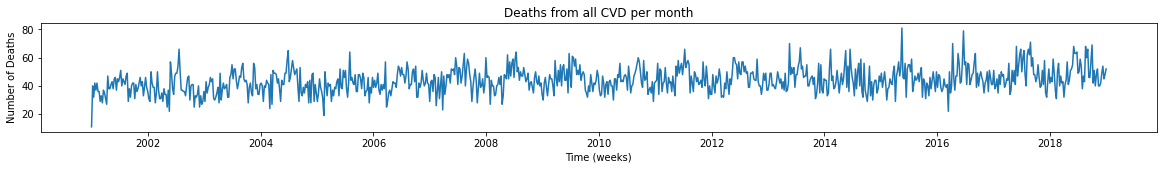

NaN count

Endog:  0
all exog datset:  0


In [34]:
endog = endog.resample('W-MON',label='right').sum()
exog = exog.resample('W-MON',label='right').sum()

plt.figure(figsize=(20,2))
plt.title('Deaths from all CVD per month')
plt.ylabel('Number of Deaths')
plt.xlabel('Time (weeks)')
plt.plot(endog)
plt.show()

#Check NaN
print('NaN count\n')
print('Endog: ',np.sum(endog.isnull()))
print('all exog datset: ',np.sum(exog.isnull()).sum())

#train/test split 80/30
n_train = int(0.8*len(exog))
endog_train = endog.iloc[:n_train].asfreq('W-MON')
endog_test = endog.iloc[n_train:].asfreq('W-MON')
exog_train = exog.iloc[:n_train].asfreq('W-MON')
exog_test = exog.iloc[n_train:].asfreq('W-MON')

##**Normalization**

In [35]:
train = pd.merge(endog_train,exog_train,on='DATE')
test = pd.merge(endog_test,exog_test,on='DATE')
test.head(3)
train.head(3)

,all,CO_MEAN,TMIN_IAC
DATE,,,
2001-01-01,11,0.804348,18.2
2001-01-08,40,8.362319,131.4
2001-01-15,32,10.222029,132.0


In [36]:
'''
set mode = 0 if you want exog NOT containing endog
set mode = 1 if you want exog containing endog
'''
mode = 0

if mode == 1:
  flag = 0
else:
  flag = 1

# load dataset
values = train.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values = values.astype('float32')

# normalize train features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(values)
# normalize test based on train scaler
test_scaled = scaler.transform(test.values)
# specify the number of lag (hours in this case, since each line equals a hour)
#n_features is the number of the exogenous variables
n_hours = 3
n_features = len(exog.columns)+mode

##**Supervised Learning**

In [37]:
# frame as supervised learning
reframed = series_to_supervised(train_scaled[:,flag:], n_hours, 0)
reframed_test = series_to_supervised(test_scaled[:,flag:], n_hours, 0)
print(reframed.shape) #nº observation x ((nºfeatures + 1) * nºlags)
reframed.head()

(749, 6)


,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
3,0.000000,0.000000,0.389105,0.810308,0.484848,0.814603
4,0.389105,0.810308,0.484848,0.814603,0.398373,0.861847
5,0.484848,0.814603,0.398373,0.861847,0.410817,0.847530
6,0.398373,0.861847,0.410817,0.847530,0.451752,0.879026
7,0.410817,0.847530,0.451752,0.879026,0.547200,0.873300


##**Reframed as 3d data**

In [38]:
# split into train and test sets
values = reframed.values

# split into input and outputs
n_obs = n_hours * n_features

#Train and test
train_X, train_y = values, train_scaled[n_hours:,0]
test_X, test_y = reframed_test.values, test_scaled[n_hours:,0]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input (train_X and test_X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(749, 6) 749 (749,)
(749, 3, 2) (749,) (185, 3, 2) (185,)


##**LSTM Fit**

Epoch 1/600
150/150 - 14s - loss: 0.0298 - val_loss: 0.0228 - 14s/epoch - 91ms/step
Epoch 2/600
150/150 - 2s - loss: 0.0145 - val_loss: 0.0221 - 2s/epoch - 11ms/step
Epoch 3/600
150/150 - 2s - loss: 0.0142 - val_loss: 0.0215 - 2s/epoch - 11ms/step
Epoch 4/600
150/150 - 2s - loss: 0.0139 - val_loss: 0.0208 - 2s/epoch - 11ms/step
Epoch 5/600
150/150 - 2s - loss: 0.0131 - val_loss: 0.0196 - 2s/epoch - 11ms/step
Epoch 6/600
150/150 - 2s - loss: 0.0123 - val_loss: 0.0188 - 2s/epoch - 11ms/step
Epoch 7/600
150/150 - 2s - loss: 0.0122 - val_loss: 0.0184 - 2s/epoch - 12ms/step
Epoch 8/600
150/150 - 2s - loss: 0.0121 - val_loss: 0.0181 - 2s/epoch - 12ms/step
Epoch 9/600
150/150 - 2s - loss: 0.0121 - val_loss: 0.0179 - 2s/epoch - 11ms/step
Epoch 10/600
150/150 - 2s - loss: 0.0120 - val_loss: 0.0177 - 2s/epoch - 11ms/step
Epoch 11/600
150/150 - 2s - loss: 0.0120 - val_loss: 0.0176 - 2s/epoch - 11ms/step
Epoch 12/600
150/150 - 2s - loss: 0.0120 - val_loss: 0.0175 - 2s/epoch - 13ms/step
Epoch 13/60

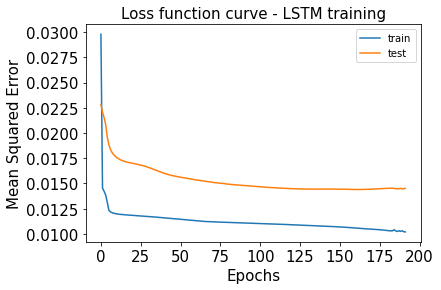

In [39]:
# design network
model = Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

#model compile
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mse', optimizer=optimizer) #loss = mean squared error (mse)

# fit network
stop = EarlyStopping(monitor='val_loss', patience=30,verbose=0,restore_best_weights=True)
callbacks_list = [stop]
history = model.fit(train_X, train_y, epochs=600, batch_size=5, validation_data=(test_X, test_y),callbacks = callbacks_list, verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss function curve - LSTM training',fontsize=15)
plt.ylabel('Mean Squared Error',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)

##**Invert Scaler**

In [40]:
#Reshape test_X to get some random columns
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
n_features = n_features-mode

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -n_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
'''
We are only interested in inverting the target variable, but the transform requires 
the same columns when inverting as when transforming. Therefore we are adding 
the target variable with other input vars for the inverse operation.
'''
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -n_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mape = mape_vectorized(inv_y,inv_yhat)
print('Test MAPE: %.3f' % mape)

Test RMSE: 8.400
Test MAPE: 13.153


##**Plot Prediction**

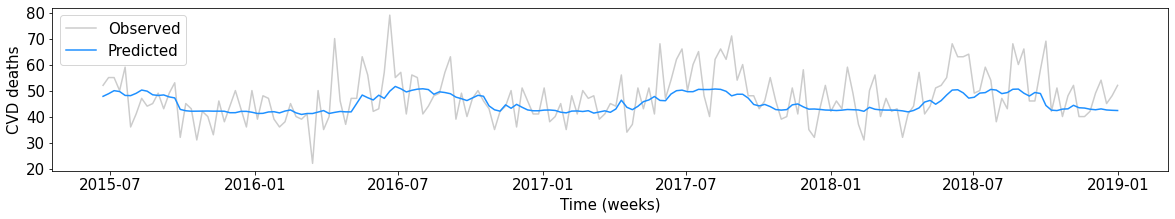

The mean value of the prediction is 45.17
The mean value of the observed time series is 47.65


In [42]:
# plot time series
plt.figure(figsize=[20,3])
plt.plot(test.iloc[n_hours:].index,inv_y[:], label='Observed',alpha=0.4,color='gray')
plt.plot(test.iloc[n_hours:].index,inv_yhat[:], label='Predicted',color='dodgerblue')
plt.xlabel('Time (weeks)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
plt.legend(fontsize=15,loc='upper left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

print(f'The mean value of the prediction is {round(inv_yhat.mean(),2)}')
print(f'The mean value of the observed time series is {round(inv_y.mean(),2)}')

#**MONTHLY DATA**

##**LOAD DATA**

In [70]:
#Deaths and environment
df = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Obitos_SSC/data/processed/2001-2018_obitos_clima_diario.csv')
df['DATE'] = pd.to_datetime(df['DATE'],dayfirst=True)
df = df.set_index('DATE')
print(df.head(3))

            CO_MIN  CO_MAX   CO_MEAN  PM10_MIN  PM10_MAX  PM10_MEAN  TMIN_IAC  \
DATE                                                                            
2001-01-01     0.6     1.2  0.804348       NaN       NaN        NaN      18.2   
2001-01-02     0.4     1.9  1.078261       NaN       NaN        NaN      17.8   
2001-01-03     0.4     2.5  1.239130       NaN       NaN        NaN      18.0   

            TMAX_IAC  TMIN_VC  TMAX_VC  ...  mi_black_F  avc_white  avc_brown  \
DATE                                    ...                                     
2001-01-01      28.2     17.8     27.9  ...           0          2          0   
2001-01-02      30.0     16.6     29.8  ...           0          1          0   
2001-01-03      30.4     17.3     29.6  ...           0          2          0   

            avc_black  avc_white_M  avc_brown_M  avc_black_M  avc_white_F  \
DATE                                                                        
2001-01-01          0            0

In [71]:
# Variables
endog = df['all']
exog = df[['TMIN_IAC','PM10_MEAN','CO_MEAN']]
endog = endog.asfreq('D')
exog = exog.asfreq('D')
#nobs = endog.shape[0]

#Check NaN
print('NaN count\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))

#fill exogenous nan with mean (for each exogenous variable)
exog = exog.fillna(exog.mean())

#Check NaN
print('NaN count\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))
exog.head(2)

NaN count

Endog             0
TMIN_IAC       0
PM10_MEAN    242
CO_MEAN      328
dtype: int64
NaN count

Endog             0
TMIN_IAC     0
PM10_MEAN    0
CO_MEAN      0
dtype: int64


,TMIN_IAC,PM10_MEAN,CO_MEAN
DATE,,,
2001-01-01,18.2,33.256795,0.804348
2001-01-02,17.8,33.256795,1.078261


##**Aggregation by month**

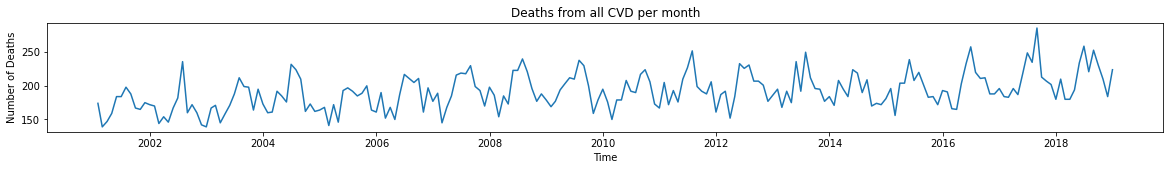

NaN count

Endog:  0
all exog datset:  0


In [72]:
endog = endog.resample('M',label='right').sum()
exog = exog.resample('M',label='right').sum()

plt.figure(figsize=(20,2))
plt.title('Deaths from all CVD per month')
plt.ylabel('Number of Deaths')
plt.xlabel('Time')
plt.plot(endog)
plt.show()

#Check NaN
print('NaN count\n')
print('Endog: ',np.sum(endog.isnull()))
print('all exog datset: ',np.sum(exog.isnull()).sum())

#train/test split 80/30
n_train = int(0.8*len(exog))
endog_train = endog.iloc[:n_train].asfreq('M')
endog_test = endog.iloc[n_train:].asfreq('M')
exog_train = exog.iloc[:n_train].asfreq('M')
exog_test = exog.iloc[n_train:].asfreq('M')

##**Normalization**

In [73]:
train = pd.merge(endog_train,exog_train,on='DATE')
test = pd.merge(endog_test,exog_test,on='DATE')
test.head(3)
train.head(3)

,all,TMIN_IAC,PM10_MEAN,CO_MEAN
DATE,,,,
2001-01-31,174,595.4,998.294991,39.506760
2001-02-28,139,556.8,933.262846,46.024819
2001-03-31,147,588.0,1110.448946,50.483390


In [74]:
'''
if exog doesn't contain endog, mode = 0
if exog does contain endog, mode = 1
'''
mode = 0

if mode == 1:
  flag = 0
else:
  flag = 1

# load dataset
values = train.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values = values.astype('float32')

# normalize train features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(values)
# normalize test based on train scaler
test_scaled = scaler.transform(test.values)
# specify the number of lag (hours in this case, since each line equals a hour)
#n_features is the number of the exogenous variables
n_hours = 3
n_features = len(exog.columns)+mode

##**Supervised Learning**

In [75]:
# frame as supervised learning
reframed = series_to_supervised(train_scaled[:,flag:], n_hours, 0)
reframed_test = series_to_supervised(test_scaled[:,flag:], n_hours, 0)
print(reframed.shape) #nº observation x ((nºfeatures + 1) * nºlags)
reframed.head()

(169, 9)


,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
3,0.845977,0.294576,0.588181,0.735057,0.237757,0.766891,0.824713,0.392566,0.889135
4,0.735057,0.237757,0.766891,0.824713,0.392566,0.889135,0.666667,0.556711,0.608476
5,0.824713,0.392566,0.889135,0.666667,0.556711,0.608476,0.357471,0.470758,0.768502
6,0.666667,0.556711,0.608476,0.357471,0.470758,0.768502,0.275287,0.595178,0.691700
7,0.357471,0.470758,0.768502,0.275287,0.595178,0.691700,0.270115,0.803179,0.872305


##**Reframed as 3d data**

In [76]:
# split into train and test sets
values = reframed.values

# split into input and outputs
n_obs = n_hours * n_features

#Train and test
train_X, train_y = values, train_scaled[n_hours:,0]
test_X, test_y = reframed_test.values, test_scaled[n_hours:,0]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input (train_X and test_X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(169, 9) 169 (169,)
(169, 3, 3) (169,) (41, 3, 3) (41,)


##**LSTM Fit**

Epoch 1/500
34/34 - 16s - loss: 0.1131 - val_loss: 0.0613 - 16s/epoch - 464ms/step
Epoch 2/500
34/34 - 0s - loss: 0.0761 - val_loss: 0.0952 - 435ms/epoch - 13ms/step
Epoch 3/500
34/34 - 0s - loss: 0.0490 - val_loss: 0.0734 - 414ms/epoch - 12ms/step
Epoch 4/500
34/34 - 0s - loss: 0.0554 - val_loss: 0.0780 - 444ms/epoch - 13ms/step
Epoch 5/500
34/34 - 0s - loss: 0.0526 - val_loss: 0.0761 - 414ms/epoch - 12ms/step
Epoch 6/500
34/34 - 0s - loss: 0.0528 - val_loss: 0.0764 - 430ms/epoch - 13ms/step
Epoch 7/500
34/34 - 0s - loss: 0.0521 - val_loss: 0.0763 - 424ms/epoch - 12ms/step
Epoch 8/500
34/34 - 0s - loss: 0.0518 - val_loss: 0.0763 - 455ms/epoch - 13ms/step
Epoch 9/500
34/34 - 0s - loss: 0.0514 - val_loss: 0.0764 - 442ms/epoch - 13ms/step
Epoch 10/500
34/34 - 0s - loss: 0.0512 - val_loss: 0.0764 - 425ms/epoch - 13ms/step
Epoch 11/500
34/34 - 0s - loss: 0.0509 - val_loss: 0.0765 - 422ms/epoch - 12ms/step
Epoch 12/500
34/34 - 0s - loss: 0.0507 - val_loss: 0.0766 - 435ms/epoch - 13ms/step
E

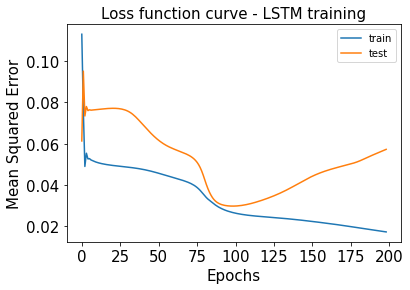

In [77]:
# design network
model = Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

#model compile
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mse', optimizer=optimizer) #loss = mean squared error (mse)

# fit network
stop = EarlyStopping(monitor='val_loss', patience=100,verbose=0,restore_best_weights=True)
callbacks_list = [stop]
history = model.fit(train_X, train_y, epochs=500, batch_size=5, validation_data=(test_X, test_y),callbacks = callbacks_list, verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss function curve - LSTM training',fontsize=15)
plt.ylabel('Mean Squared Error',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)

##**Invert Scaler**

In [78]:
#Reshape test_X to get 7 random columns
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
n_features = n_features-mode

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -n_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
'''
We are only interested in inverting the target variable, but the transform requires 
the same columns when inverting as when transforming. Therefore we are adding 
the target variable with other input vars for the inverse operation.
'''
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -n_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mape = mape_vectorized(inv_y,inv_yhat)
print('Test MAPE: %.3f' % mape)

Test RMSE: 19.493
Test MAPE: 7.235


##**Plot Prediction**

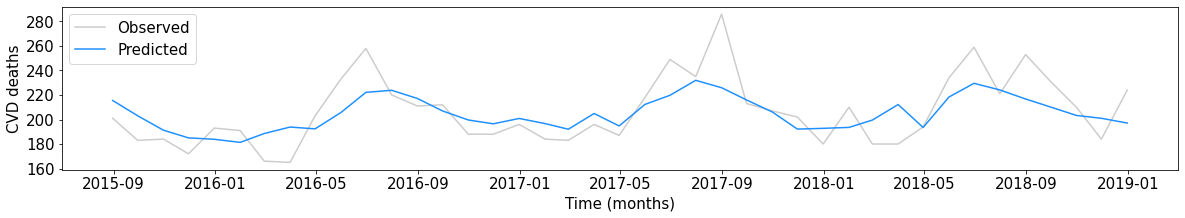

The mean value of the prediction is 204.69
The mean value of the time series is 206.93


In [79]:
# plot time series
plt.figure(figsize=[20,3])
plt.plot(test.iloc[n_hours:].index,inv_y[:], label='Observed',alpha=0.4,color='gray')
plt.plot(test.iloc[n_hours:].index,inv_yhat[:], label='Predicted',color='dodgerblue')
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
plt.legend(fontsize=15,loc='upper left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

print(f'The mean value of the prediction is {round(inv_yhat.mean(),2)}')
print(f'The mean value of the time series is {round(inv_y.mean(),2)}')